<a href="https://colab.research.google.com/github/UnitForDataScience/Chest-X-Ray-Image-Classifier/blob/master/Chest_X_Ray_Image_Classification_(Neural_Networks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project was inspired by work done with ASU's [Lunar Reconnaissance Orbiter Camera](https://www.lroc.asu.edu/) (LROC) team in identifying & classifying moon craters. However, due to some data constraints, we designed this notebook to work as an intermediate step in our moon crater project. Any findings here will be incorporated into that project as it progresses. 

The data chosen as a stand in for our moon craters is the chest x-ray dataset, which is moderately well-known among machine learning developers. This set contains over 5,000 x-ray images classified into lungs that have Pneumonia and those that are considered normal. This set was chosen because of its overall objective and image properties being similar to our moon crater images. Furthermore, applications of data science in the prediction and treatment of the sick is a rapidly expanding field that many find fulfilling. 

Here we have applied a convolutional neural network (CNN) from scratch and evaluated its performance. Your task here is to either 1) adjust and improve the current routine or 2) implement any other image classifying routine of your choice and compare the results. We are interested in any results or findings developed. 

<br>
For more information on CNNs, see the following: 

https://en.wikipedia.org/wiki/Convolutional_neural_network

<br>
Furthermore, this project was originally a Kaggle project with more information found here:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/

<br>
For a broader and more technical discussion on medical diagnosing with deep learning, see here:

https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

---
# Data Import and Initialization

As stated in the text cell above, the data is an image file directory containing x-ray images of lungs with and without Pneumonia. The directory is split into training and test sets. Please note that the Kaggle version has a 3rd validation directory, which we are not implementing here. We will be using the test set as validation. The original images are of varying dimensions but are relatively large (>~1,000 x 1,000) and are grayscale, despite containing 3 channels. The data is pulled from a public repository and all handled within Google Colab, so no external downloads are necessary. However, it does take a few minutes for the data to fully load. 

<br> 
The .zip file and some minor detail about the dataset can be found here (labeled "ChestXRay2017.zip"):

https://data.mendeley.com/datasets/rscbjbr9sj/2


In [1]:
%tensorflow_version 2.x # Specifying TensorFlow version 2 (To be removed once default in Colab)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Specifying TensorFlow version 2 (To be removed once default in Colab)`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
# Necessary package imports

import os
import zipfile
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.io import imread

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

print('Imports completed successfully')

Imports completed successfully


In [3]:
# Downloading full dataset into the runtime encironment, takes ~2 minutes
!wget --no-check-certificate \
    https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded

--2021-06-28 18:31:13--  https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2021-06-28 18:31:13--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.53.179
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.53.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1235512464 (1.2G) [applicat

In [4]:
# Unzipping file to local directory, takes ~2 minutes or so as well
zip_name = 'file_downloaded'
zip_file = zipfile.ZipFile(zip_name, 'r')
zip_file.extractall()
zip_file.close()

# Assigning directories
norm_train_dir = 'chest_xray/train/NORMAL'
pne_train_dir = 'chest_xray/train/PNEUMONIA'

norm_test_dir = 'chest_xray/test/NORMAL'
pne_test_dir = 'chest_xray/test/PNEUMONIA'

# generating lists of filenames
norm_train_files = os.listdir(norm_train_dir )
pne_train_files = os.listdir(pne_train_dir )
norm_test_files = os.listdir(norm_test_dir )
pne_test_files = os.listdir(pne_test_dir )

# User output validation (NOTE: file names should all be different)
print(norm_train_files[:5]) 
print(pne_train_files[:5])
print(norm_test_files[:5]) 
print(pne_test_files[:5])

['IM-0640-0001.jpeg', 'NORMAL2-IM-1150-0001.jpeg', 'IM-0545-0001.jpeg', 'NORMAL2-IM-0623-0001.jpeg', 'IM-0510-0001.jpeg']
['person530_bacteria_2233.jpeg', 'person382_bacteria_1746.jpeg', 'person701_virus_1297.jpeg', 'person26_bacteria_122.jpeg', 'person39_bacteria_198.jpeg']
['NORMAL2-IM-0139-0001.jpeg', 'NORMAL2-IM-0313-0001.jpeg', 'NORMAL2-IM-0173-0001-0002.jpeg', 'NORMAL2-IM-0286-0001.jpeg', 'NORMAL2-IM-0305-0001.jpeg']
['person1645_virus_2845.jpeg', 'person142_bacteria_682.jpeg', 'person79_virus_148.jpeg', 'person1669_virus_2884.jpeg', 'person110_bacteria_531.jpeg']


In [5]:
# Count of images

norm_train_n = len(norm_train_files)
norm_test_n = len(norm_test_files)
pne_train_n = len(pne_train_files)
pne_test_n = len(pne_test_files)

print('Total normal training images:', norm_train_n)
print('Total normal testing images:', norm_test_n)
print('Total pneumonic training images:', pne_train_n)
print('Total pneumonic testing images:', pne_test_n)

Total normal training images: 1349
Total normal testing images: 234
Total pneumonic training images: 3884
Total pneumonic testing images: 390


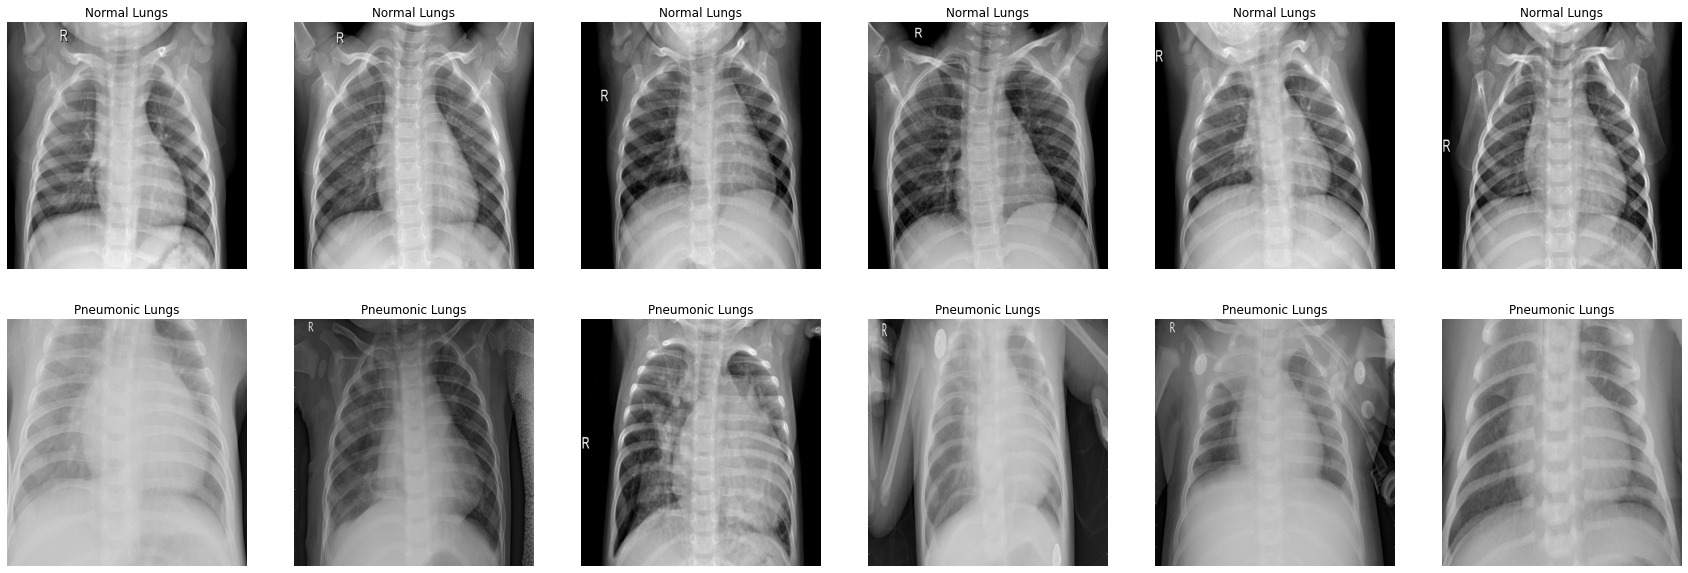

In [6]:
# Displaying sample images to user 

%matplotlib inline

imgs_per_class = 6 # Number of samples to output per class

# Getting paths to samples
norm_sample = [os.path.join(norm_train_dir, nm) 
                          for nm in norm_train_files[:imgs_per_class]]
pne_sample = [os.path.join(pne_train_dir, nm) 
                          for nm in pne_train_files[:imgs_per_class]]

# Forming single list of image paths
sample_list =  norm_sample + pne_sample

# Plotting of images
f, ax = plt.subplots(2,imgs_per_class, figsize=(30,10))
for i in range(imgs_per_class*2):

    img = imread(sample_list[i])
    ax[i//imgs_per_class, i%imgs_per_class].imshow(img, cmap='gray')

    if i<imgs_per_class:
        ax[i//imgs_per_class, i%imgs_per_class].set_title("Normal Lungs")
    else:
        ax[i//imgs_per_class, i%imgs_per_class].set_title("Pneumonic Lungs")
        
    ax[i//imgs_per_class, i%imgs_per_class].axis('off')
    ax[i//imgs_per_class, i%imgs_per_class].set_aspect('auto')
plt.show()

# Convolutional Neural Network Setup

The CNN here is through TensorFlow and Keras. There are a very large number of parameters here to adjust. However, please be conscious of their impact on model fitting. A miner change in number here could add hours to your processing time. 

It is also recommended that the Python runtime environment have hardware acceleration enabled. To do this, go to Runtime->Change runtime type, and select GPU under the "Hardware accelerator" dropdown. PLEASE NOTE that if this is changed it will reset the runtime environment and data will need to be re-imported if already executed. 

<br>
For more general information on TensorFlow, see: 

https://en.wikipedia.org/wiki/TensorFlow

https://www.tensorflow.org/


<br> 
For more detail on the Keras package implementation within Tensorflow, see: 

https://www.tensorflow.org/api_docs/python/tf/keras/Model

<br>
Lastly, here are a few great blog posts discussing the basics for understanding CNNs: 

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/


In [7]:
# Our input feature map is 224x224x3: 224x224 for the image pixels
img_input = layers.Input(shape=(224, 224, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [8]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0     

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'chest_xray/train',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        'chest_xray/test',
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


---
# Model Fitting

There is much interest here regarding multiprocessing and GPU utilization. Our team has not been able to much in the way of research on this so far, especially within the Colab runtime environment. Please inform us of any developments you find! 

NOTE: This can take upwards of 15 minutes to complete with its current settings.

In [12]:
history = model.fit(
      train_generator,
      steps_per_epoch=250,  # 5000 images = batch_size * steps
      epochs=15,
      validation_data=test_generator,
      validation_steps=30,  # 600 images = batch_size * steps
      verbose=2) 

Epoch 1/15
250/250 - 84s - loss: 0.3139 - acc: 0.8910 - val_loss: 0.9003 - val_acc: 0.7817
Epoch 2/15
250/250 - 52s - loss: 0.1283 - acc: 0.9601 - val_loss: 0.9484 - val_acc: 0.7667
Epoch 3/15
250/250 - 52s - loss: 0.0938 - acc: 0.9704 - val_loss: 0.8563 - val_acc: 0.7383
Epoch 4/15
250/250 - 52s - loss: 0.0676 - acc: 0.9736 - val_loss: 1.1746 - val_acc: 0.7567
Epoch 5/15
250/250 - 52s - loss: 0.0517 - acc: 0.9826 - val_loss: 1.5513 - val_acc: 0.7767
Epoch 6/15
250/250 - 51s - loss: 0.0458 - acc: 0.9868 - val_loss: 1.2426 - val_acc: 0.7900
Epoch 7/15
250/250 - 51s - loss: 0.0399 - acc: 0.9884 - val_loss: 2.1342 - val_acc: 0.7350
Epoch 8/15
250/250 - 53s - loss: 0.0269 - acc: 0.9910 - val_loss: 2.8466 - val_acc: 0.7217
Epoch 9/15
250/250 - 52s - loss: 0.0237 - acc: 0.9912 - val_loss: 3.0145 - val_acc: 0.7483
Epoch 10/15
250/250 - 52s - loss: 0.0234 - acc: 0.9940 - val_loss: 2.8259 - val_acc: 0.7033
Epoch 11/15
250/250 - 52s - loss: 0.0136 - acc: 0.9952 - val_loss: 3.5097 - val_acc: 0.73

# Visualizing Model Layers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


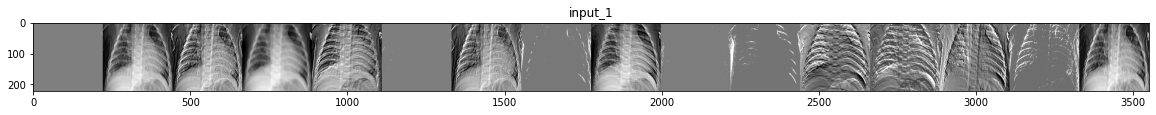

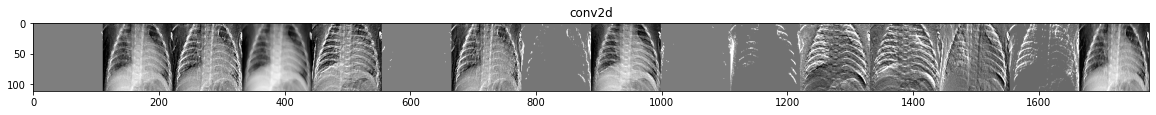

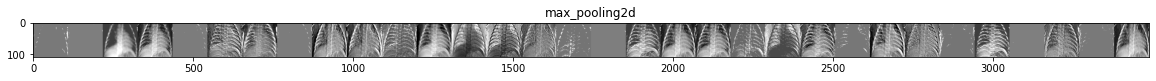

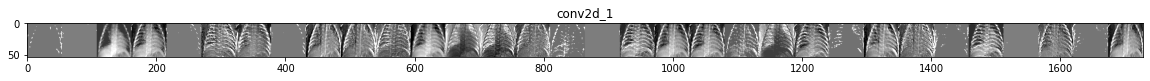

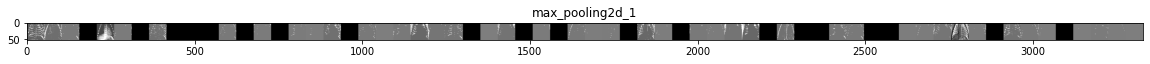

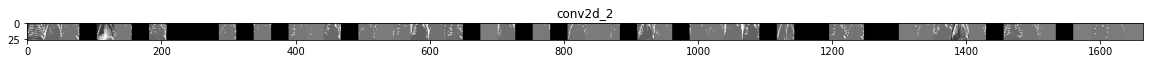

In [13]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image from the training set.
norm_image_files = [os.path.join('chest_xray/train/NORMAL', f) for f in norm_train_files]
pne_image_files = [os.path.join('chest_xray/train/PNEUMONIA', f) for f in pne_train_files]
img_path = random.choice(norm_image_files + pne_image_files)

img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (224, 224, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 224, 224, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')

---
# Model Performance

Some detail on some performance evaluation metrics:

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

Text(0.5, 1.0, 'Training and validation loss')

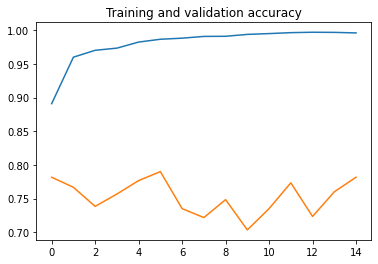

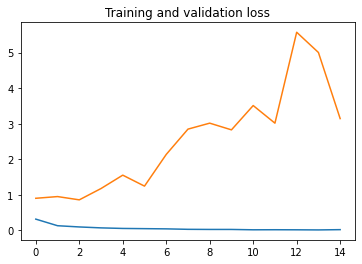

In [14]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

---
# Hyperparameter Optimization

As a secondary task, build a framework that optimizes the parameters of any of the algorithms implemented. This can be done through grid search, random search, or even manually adjusting parameters on your own. For more information on hyperparameter optimization, please see the following: 

https://en.wikipedia.org/wiki/Hyperparameter_optimization

In [15]:
# Code block for hyperparameter optimization